In [1]:
import os
import keras
import tensorflow as tf

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Configuration

In [2]:
class CFG:
    # General settings
    verbose = 1  # Verbosity
    seed = 42  # Random seed
    preset = "efficientnetv2_b0_imagenet"  # Name of pretrained classifier
    image_size = (224, 224)  # Input image size

    # Training settings
    batch_size = 96  # Batch size
    lr_mode = "cos"  # LR scheduler mode from one of "cos", "step", "exp"
    drop_remainder = True  # Drop incomplete batches

    # Dataset settings
    num_folds = 5  # Number of folds to split the dataset
    fold = 0  # Which fold to set as validation data
    class_names = ['Malignant' , 'Benign',]
    num_classes = 1
    epochs = 50

In [3]:
tf.random.set_seed(CFG.seed)

# Load Dataset

In [4]:
BASE_PATH = "./kaggle/input/isic-2019"

In [5]:
metadata = pd.read_csv(f'{BASE_PATH}/ISIC_2019_Training_Metadata.csv')
ground_truth = pd.read_csv(f'{BASE_PATH}/ISIC_2019_Training_GroundTruth.csv')
# Concatenate the two DataFrames based on the 'image' column
merge_df = pd.merge(ground_truth, metadata, on='image').drop('lesion_id', axis=1)
merge_df['target'] = merge_df[['MEL', 'BCC', 'AK', 'SCC']].sum(axis=1) # 1 for Malignant
diagnosis_map = {0: 'benign', 1: 'malignant'}
merge_df['diagnosis'] = merge_df['target'].map(diagnosis_map)
df = merge_df.loc[:, ['image', 'target', 'diagnosis']]
df['images'] = f'{BASE_PATH}/ISIC_2019_Training_Input/ISIC_2019_Training_Input/' + df['image'] + '.jpg'
# data['anatom_site_general'] = data['anatom_site_general'].replace(['lateral torso', 'anterior torso', 'posterior torso'], 'torso')
df.head()

,image,target,diagnosis,images
0,ISIC_0000000,0.0,benign,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...
1,ISIC_0000001,0.0,benign,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...
2,ISIC_0000002,1.0,malignant,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...
3,ISIC_0000003,0.0,benign,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...
4,ISIC_0000004,1.0,malignant,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...


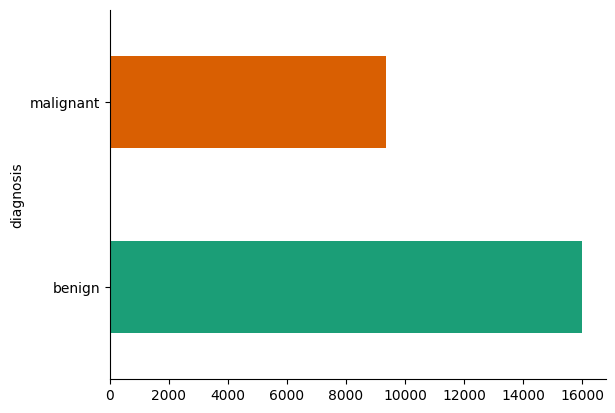

In [6]:
# @title diagnosis

import seaborn as sns
df.groupby('diagnosis').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [7]:
# Split the dataset into features and target
X = df[["images"]]
y = df["target"]

# Convert target values to float32
y = y.astype('float32')

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X, y = X_test, y_test
X_validation, X_test, y_validation, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)

# Create a TensorFlow dataset from the preprocessed data
def load_and_preprocess_image(image_path):
    # Read and preprocess image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, CFG.image_size)  # adjust size as needed
    return image

def create_tf_dataset(X, y, batch_size=32, shuffle=True,repeat =True):
    image_paths = X['images'].tolist()
    X.drop('images',axis=1,inplace=True)
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, y))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(X))

    # Read and preprocess images, include them in the batch
    def load_image(image_path, label):
        image = load_and_preprocess_image(image_path)
        return image, label

    dataset = dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    return dataset

batch_size = CFG.batch_size
train_dataset = create_tf_dataset(X_train, y_train, batch_size=batch_size)
validation_dataset = create_tf_dataset(X_validation, y_validation, batch_size=batch_size, shuffle=False)
test_dataset = create_tf_dataset(X_test, y_test, batch_size=batch_size, shuffle=False)

# Setup base model (EfficientNet)

In [8]:
preprocess_input = tf.keras.applications.efficientnet_v2.preprocess_input

In [9]:
# Create the base model from the pre-trained model EfficientNet V2
input_shape = CFG.image_size + (3,)
base_model = tf.keras.applications.EfficientNetV2B0(input_shape=input_shape,
                                                    include_top=False,
                                                    pooling="avg",
                                                    weights='imagenet')
base_model.trainable = False

# Let's take a look at the base model architecture
base_model.summary()

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 56, 56,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 56, 56,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 56, 56,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 56, 56,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 56, 56,    │          0 │ block2b_expand_b

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,919,312 (22.58 MB)

In [10]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

# Create Model

In [11]:
# Create the model
inputs = tf.keras.Input(shape=input_shape)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(2048, activation="selu")(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(1024, activation="selu")(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# Compile model

In [12]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

# Print model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 1280)           │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2048)           │     2,623,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,642,001 (40.60 MB)

 Trainable params: 4,722,689 (18.02 MB)

 Non-trainable params: 5,919,312 (22.58 MB)

# Train model

In [13]:
initial_epochs = CFG.epochs

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/50
  3/159 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - accuracy: 0.6013 - loss: 2.7109

I0000 00:00:1716512135.273965      66 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


159/159 ━━━━━━━━━━━━━━━━━━━━ 186s 867ms/step - accuracy: 0.7007 - loss: 1.1636 - val_accuracy: 0.7430 - val_loss: 0.4916
Epoch 2/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 60s 380ms/step - accuracy: 0.7717 - loss: 0.4692 - val_accuracy: 0.7694 - val_loss: 0.4645
Epoch 3/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 82s 380ms/step - accuracy: 0.7745 - loss: 0.4578 - val_accuracy: 0.7813 - val_loss: 0.4491
Epoch 4/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 60s 379ms/step - accuracy: 0.7850 - loss: 0.4487 - val_accuracy: 0.7961 - val_loss: 0.4268
Epoch 5/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 60s 377ms/step - accuracy: 0.7798 - loss: 0.4522 - val_accuracy: 0.7655 - val_loss: 0.4753
Epoch 6/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 60s 376ms/step - accuracy: 0.7827 - loss: 0.4386 - val_accuracy: 0.7700 - val_loss: 0.4651
Epoch 7/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 60s 379ms/step - accuracy: 0.7831 - loss: 0.4408 - val_accuracy: 0.8024 - val_loss: 0.4239
Epoch 8/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 60s 378ms/step - accuracy: 0.7977 - loss: 0.4223 - va

# Plot Training

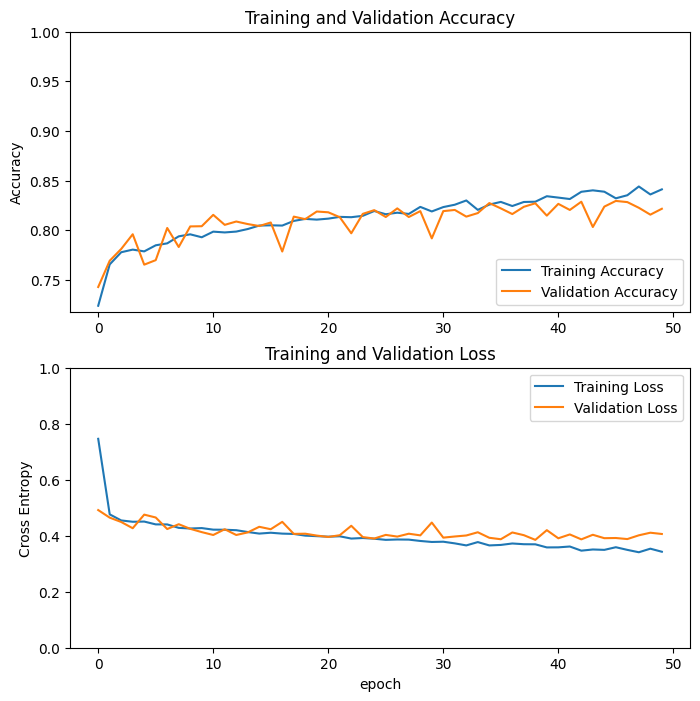

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [15]:
from sklearn.metrics import roc_curve
y_pred = model.predict(test_dataset).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

53/53 ━━━━━━━━━━━━━━━━━━━━ 42s 669ms/step


In [16]:
from sklearn.metrics import auc
auc_score = auc(fpr, tpr)

In [17]:
y_pred = tf.where(y_pred < 0.5, 0, 1)

In [18]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.80      0.94      0.86      3199
         1.0       0.85      0.59      0.70      1868

    accuracy                           0.81      5067
   macro avg       0.82      0.77      0.78      5067
weighted avg       0.82      0.81      0.80      5067



In [19]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

[[3007  192]
 [ 762 1106]]


# Fine tune base model

In [20]:
base_model.trainable = True

In [21]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  271


In [22]:
# Fine-tune from this layer onwards
start_fine_tune_at = 261

# Freeze all the layers before the `start_fine_tune_at` layer
for layer in base_model.layers[:start_fine_tune_at]:
  layer.trainable = False

# Recompile model

In [23]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 1280)           │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2048)           │     2,623,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,642,001 (40.60 MB)

 Trainable params: 5,249,025 (20.02 MB)

 Non-trainable params: 5,392,976 (20.57 MB)

# Retrain model

In [24]:
fine_tune_epochs = CFG.epochs
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)


Epoch 51/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 141s 615ms/step - accuracy: 0.7714 - loss: 1.5476 - val_accuracy: 0.8156 - val_loss: 0.4927
Epoch 52/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 60s 378ms/step - accuracy: 0.8231 - loss: 0.4633 - val_accuracy: 0.8269 - val_loss: 0.4136
Epoch 53/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 60s 378ms/step - accuracy: 0.8370 - loss: 0.3753 - val_accuracy: 0.8296 - val_loss: 0.3958
Epoch 54/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 60s 380ms/step - accuracy: 0.8497 - loss: 0.3309 - val_accuracy: 0.8326 - val_loss: 0.3954
Epoch 55/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 60s 376ms/step - accuracy: 0.8552 - loss: 0.3237 - val_accuracy: 0.8324 - val_loss: 0.3951
Epoch 56/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 83s 381ms/step - accuracy: 0.8551 - loss: 0.3221 - val_accuracy: 0.8401 - val_loss: 0.3770
Epoch 57/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 60s 379ms/step - accuracy: 0.8622 - loss: 0.3085 - val_accuracy: 0.8427 - val_loss: 0.3772
Epoch 58/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 60s 379ms/step - accuracy:

# Plot retraining

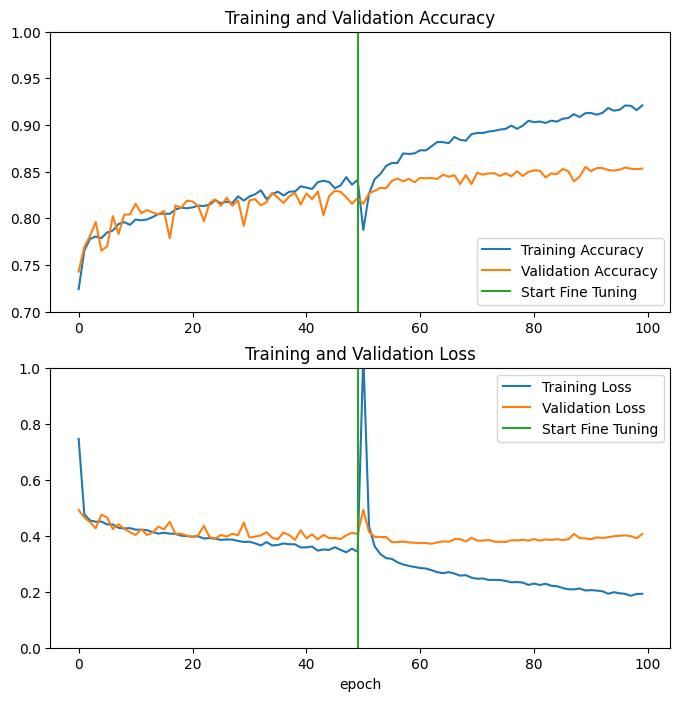

In [25]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.7, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Evaluate training

In [26]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 351ms/step - accuracy: 0.8376 - loss: 0.4169
Test accuracy : 0.8431024551391602


In [27]:
from sklearn.metrics import roc_curve
fine_y_pred = model.predict(test_dataset).ravel()
fine_fpr, fine_tpr, fine_thresholds = roc_curve(y_test, fine_y_pred)

53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 361ms/step


In [28]:
from sklearn.metrics import auc
fine_auc_score = auc(fine_fpr, fine_tpr)

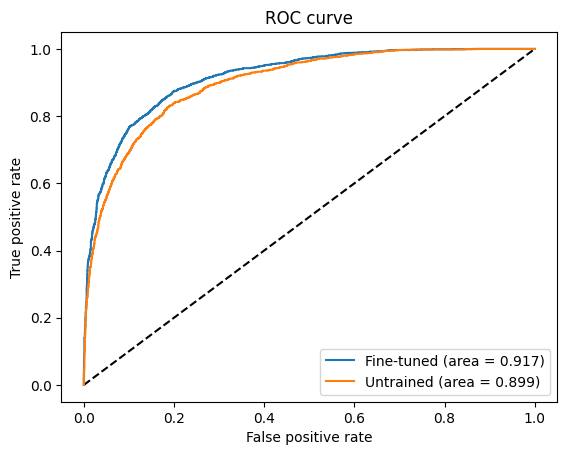

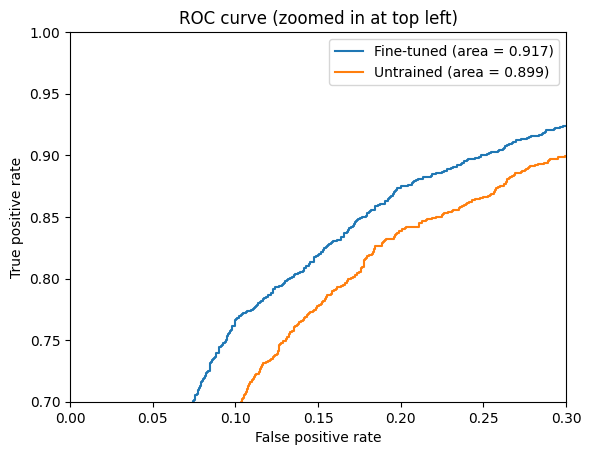

In [29]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fine_fpr, fine_tpr, label='Fine-tuned (area = {:.3f})'.format(fine_auc_score))
plt.plot(fpr, tpr, label='Untrained (area = {:.3f})'.format(auc_score))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.3)
plt.ylim(0.7, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fine_fpr, fine_tpr, label='Fine-tuned (area = {:.3f})'.format(fine_auc_score))
plt.plot(fpr, tpr, label='Untrained (area = {:.3f})'.format(auc_score))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [30]:
fine_y_pred = tf.where(fine_y_pred < 0.5, 0, 1)

In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_test, fine_y_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.87      0.88      3199
         1.0       0.78      0.79      0.79      1868

    accuracy                           0.84      5067
   macro avg       0.83      0.83      0.83      5067
weighted avg       0.84      0.84      0.84      5067



In [32]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, fine_y_pred))

[[2789  410]
 [ 385 1483]]


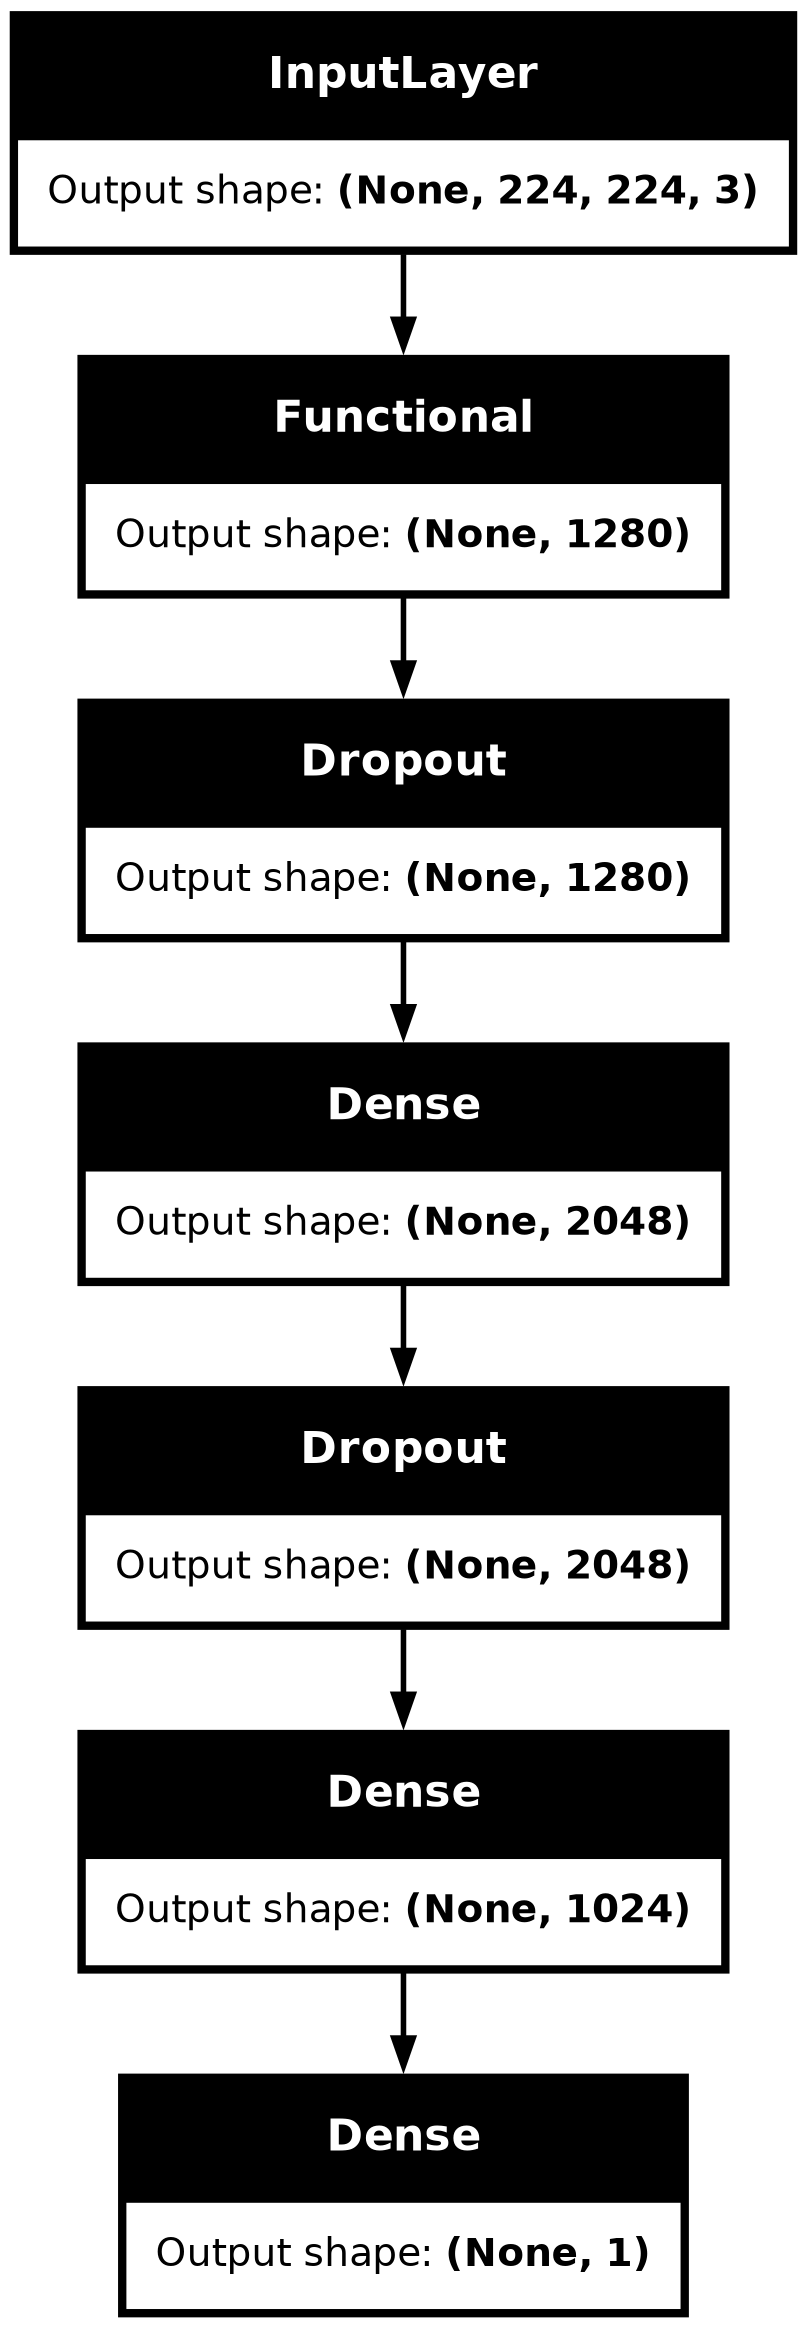

In [33]:
keras.utils.plot_model(model, show_shapes=True)